# Validation of the normal distribution
Validate that generated data comes from the normal distribution.

1. Generate normal distribution dataset and obtain original coefficients on which the normal distribution was built.
2. Check that the generated dataset has these coefficients close enough to the original ones.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as tt

from app import Generator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
g = Generator(n_rows=2500,
     n_columns=200,
     informative_ratio=0.75,
     distribution='norm',
     gaussian_sigma2=1,
)

df = g.generate_data()

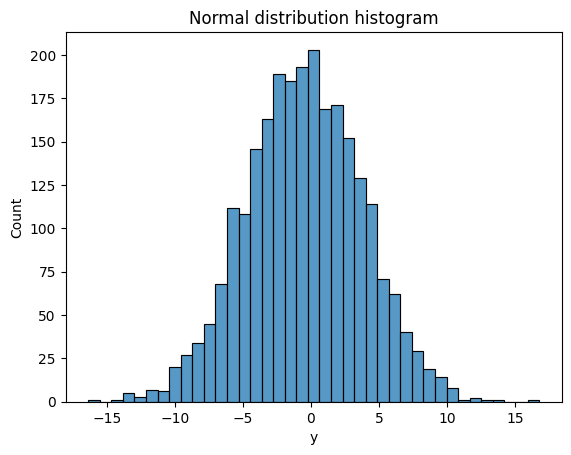

In [3]:
df.head()
plt.title('Normal distribution histogram')
sns.histplot(df['y'])
plt.show()

# PyMC Normal
Use the PyMC module to obtain the original coefficients.

In [4]:
model = pm.Model()

X = df.drop(columns=['y', 'y_exact'])
y = df['y']

with model:
    # Priors for model parameters
    intercept = pm.Normal('Intercept', mu=0, sigma=2)
    coefficients = pm.Normal('beta', mu=0, sigma=1, shape=X.shape[1])
    
    # Linear combination of features and coefficients
    mu = intercept + tt.dot(X, coefficients)
    
    y_obs = pm.Normal('y_obs', mu=mu, sigma=1, observed=y)
    trace = pm.sample(200, tune=1000, target_accept=0.95)

coefficients_summary = pm.summary(trace)['mean']
print(coefficients_summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta]


Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 164 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Intercept   -0.526
beta[0]     -0.019
beta[1]     -0.064
beta[2]      0.254
beta[3]     -0.855
             ...  
beta[195]   -0.320
beta[196]   -0.125
beta[197]   -0.058
beta[198]   -0.891
beta[199]    0.027
Name: mean, Length: 201, dtype: float64


## Comparison
Compare the original coefficients with the coefficients obtained with PyMC.

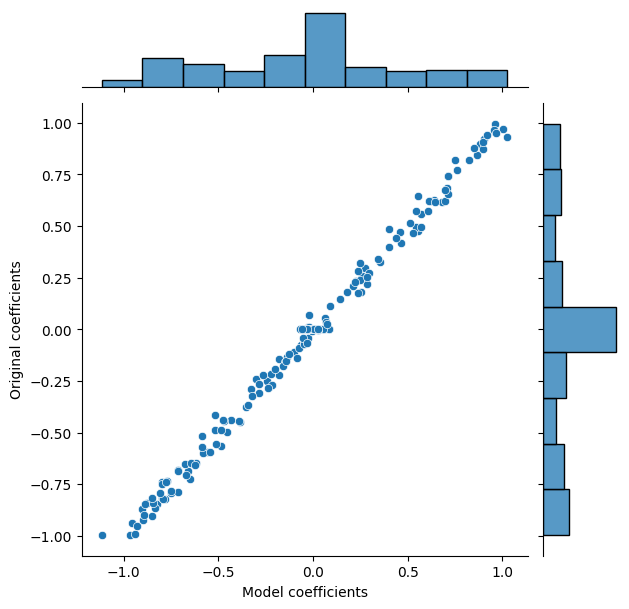

In [6]:
sns.jointplot(x=coefficients_summary.iloc[1:].tolist(), y=g.coef_)
plt.xlabel('Model coefficients')
plt.ylabel('Original coefficients')
plt.show()

As may be seen, PyMC was successful and the generated data comes from the normal distribution.